TODO:</br>
topic coherence [metrics](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/topic_coherence-movies.ipynb)</br>

compare multiple models</br>
*   nmf
*   bert

Compare multiple models with [Octis](https://github.com/mind-Lab/octis)

HDP<br/>
[Part I](https://towardsdatascience.com/dont-be-afraid-of-nonparametric-topic-models-d259c237a840)<br/>
[Part II](https://towardsdatascience.com/dont-be-afraid-of-nonparametric-topic-models-part-2-python-e5666db347a)<br/>
[notebook](https://github.com/ecoronado92/towards_data_science/blob/master/hdp_example/hdp_example.ipynb)

## Setup

In [5]:
!pip install -q pandas
!pip install -q gensim
!pip install -q pynndescent>=0.4
!pip install -q umap-learn
!pip install -q hdbscan
!pip install -q wordcloud
!pip install -q tensorflow
!pip install -q tensorflow_hub
!pip install -q tensorflow_text
!pip install -q torch
!pip install -q sentence_transformers
!pip install -q hnswlib
!pip install -q joblib<1.0.0
!pip install -q numpy
!pip install -q top2vec[sentence_transformers]

     |████████████████████████████████| 14.8 MB 158 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
top2vec 1.0.26 requires numpy>=1.20.0, but you have numpy 1.19.5 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
bertopic 0.9.1 requires numpy>=1.20.0, but you have numpy 1.19.5 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
/bin/bash: 1.0.0: No such file or directory
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires numpy~=1.19.2, but you have numpy 1.21.2 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatib

In [6]:
!pip3 install -q bertopic[all]

In [7]:
# &> /dev/null - hides output
!pip install spacy &> /dev/null
!spacy download en &> /dev/null
!pip install pyLDAvis==2.1.2 &> /dev/null

Imports

In [8]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

import matplotlib.pyplot as plt
import pandas as pd
import spacy
import numpy as np

from bertopic import BERTopic
from top2vec import Top2Vec
import pyLDAvis
import pyLDAvis.sklearn
import re
from pprint import pprint
from tqdm import tqdm
from IPython.core.display import HTML
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


Settings

In [9]:
use_sub_categories = True
categories = ['alt.atheism', 'sci.space', 'soc.religion.christian', 'talk.politics.guns']
RANDOM_STATE = 42

Load dataset

In [10]:
newsgroups_train_cleaned = fetch_20newsgroups(subset='train', 
                                              remove=('headers', 'footers', 'quotes'), 
                                              categories = categories if use_sub_categories else None,
                                              shuffle=True, 
                                              random_state=RANDOM_STATE)

X = newsgroups_train_cleaned.data
y = newsgroups_train_cleaned.target
target_names = newsgroups_train_cleaned.target_names

## Compare Topic Models

### Prepare data for deep learning models

In [11]:
def light_preprocess(text):
    text = text.strip()
    text = re.sub('\d', '', text)  # remove numbers 
    text = ' '.join(text.split())  # replace whitespace with single space
    return text

In [12]:
docs = [light_preprocess(x) for x in X]

### Top2Vec

[Github](https://github.com/ddangelov/Top2Vec)

In [13]:
model = Top2Vec(docs, embedding_model='universal-sentence-encoder')

2021-09-16 10:38:27,439 - top2vec - INFO - Pre-processing documents for training
2021-09-16 10:38:29,247 - top2vec - INFO - Downloading universal-sentence-encoder model
INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/4'.
INFO:absl:Downloaded https://tfhub.dev/google/universal-sentence-encoder/4, Total size: 987.47MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/4'.
2021-09-16 10:38:47,188 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2021-09-16 10:39:05,519 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2021-09-16 10:39:27,074 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2021-09-16 10:39:27,192 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


In [14]:
model.get_num_topics()

2

In [15]:
topic_words, word_scores, topic_nums = model.get_topics()

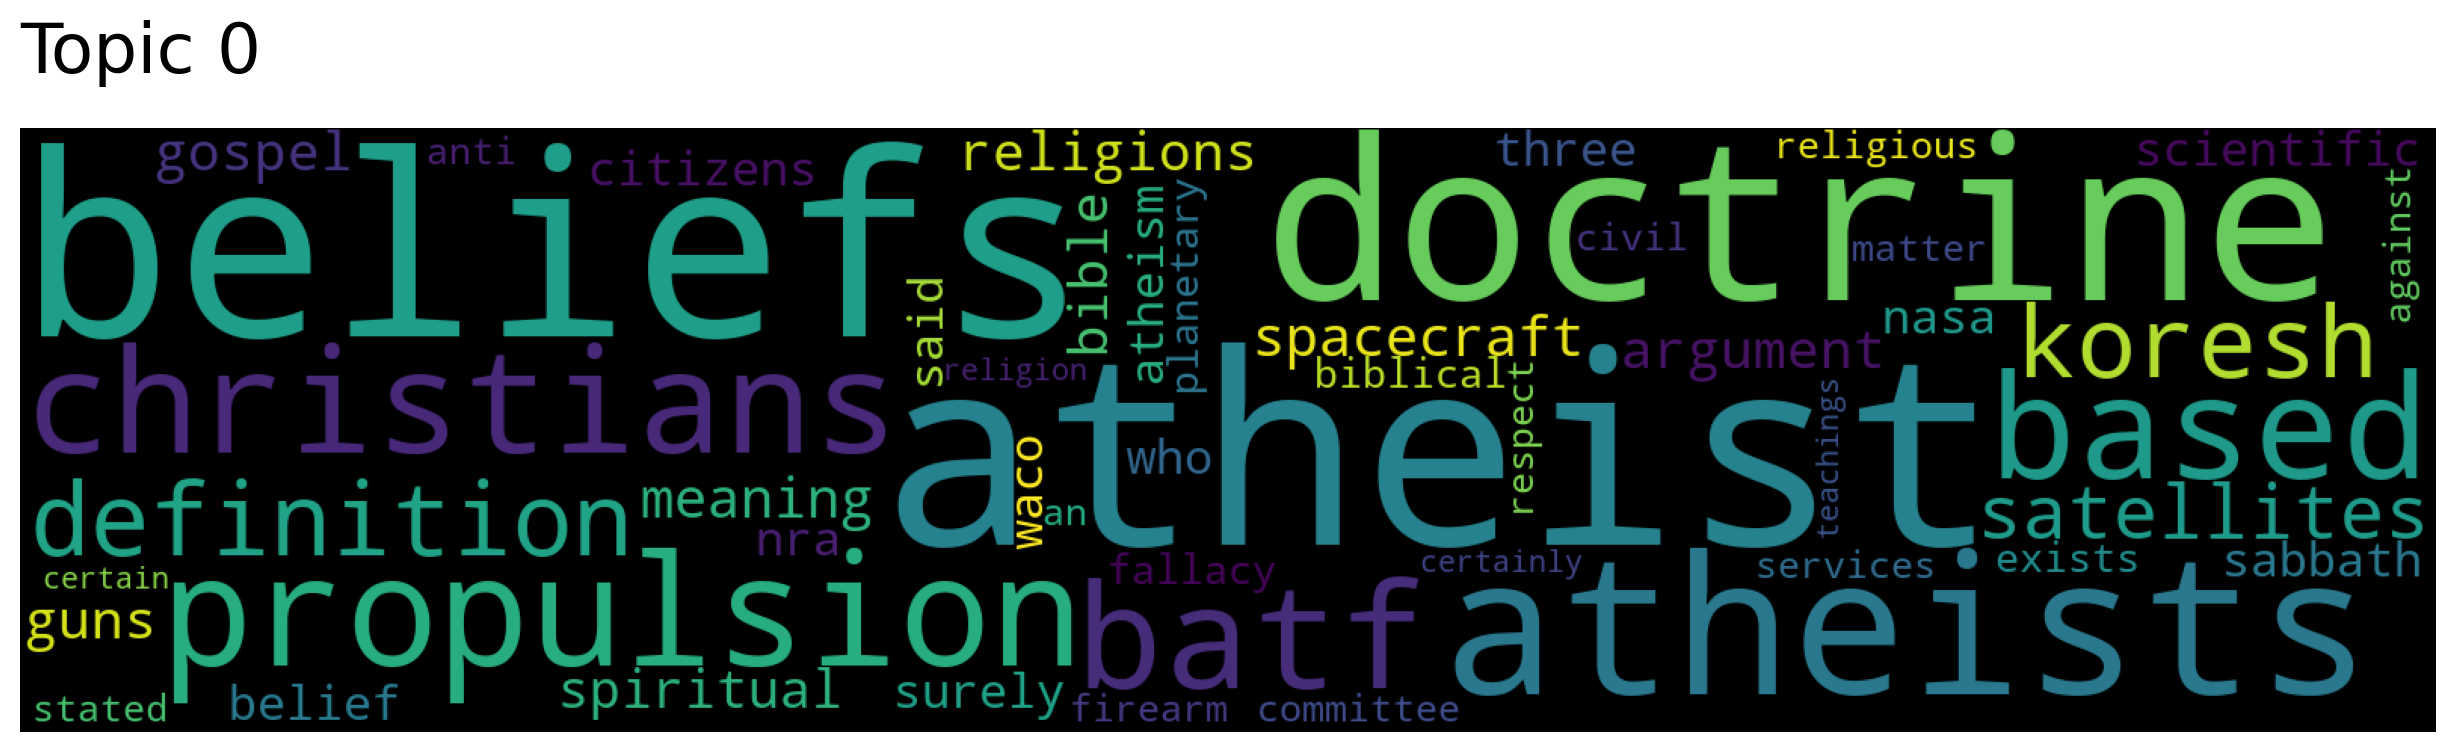

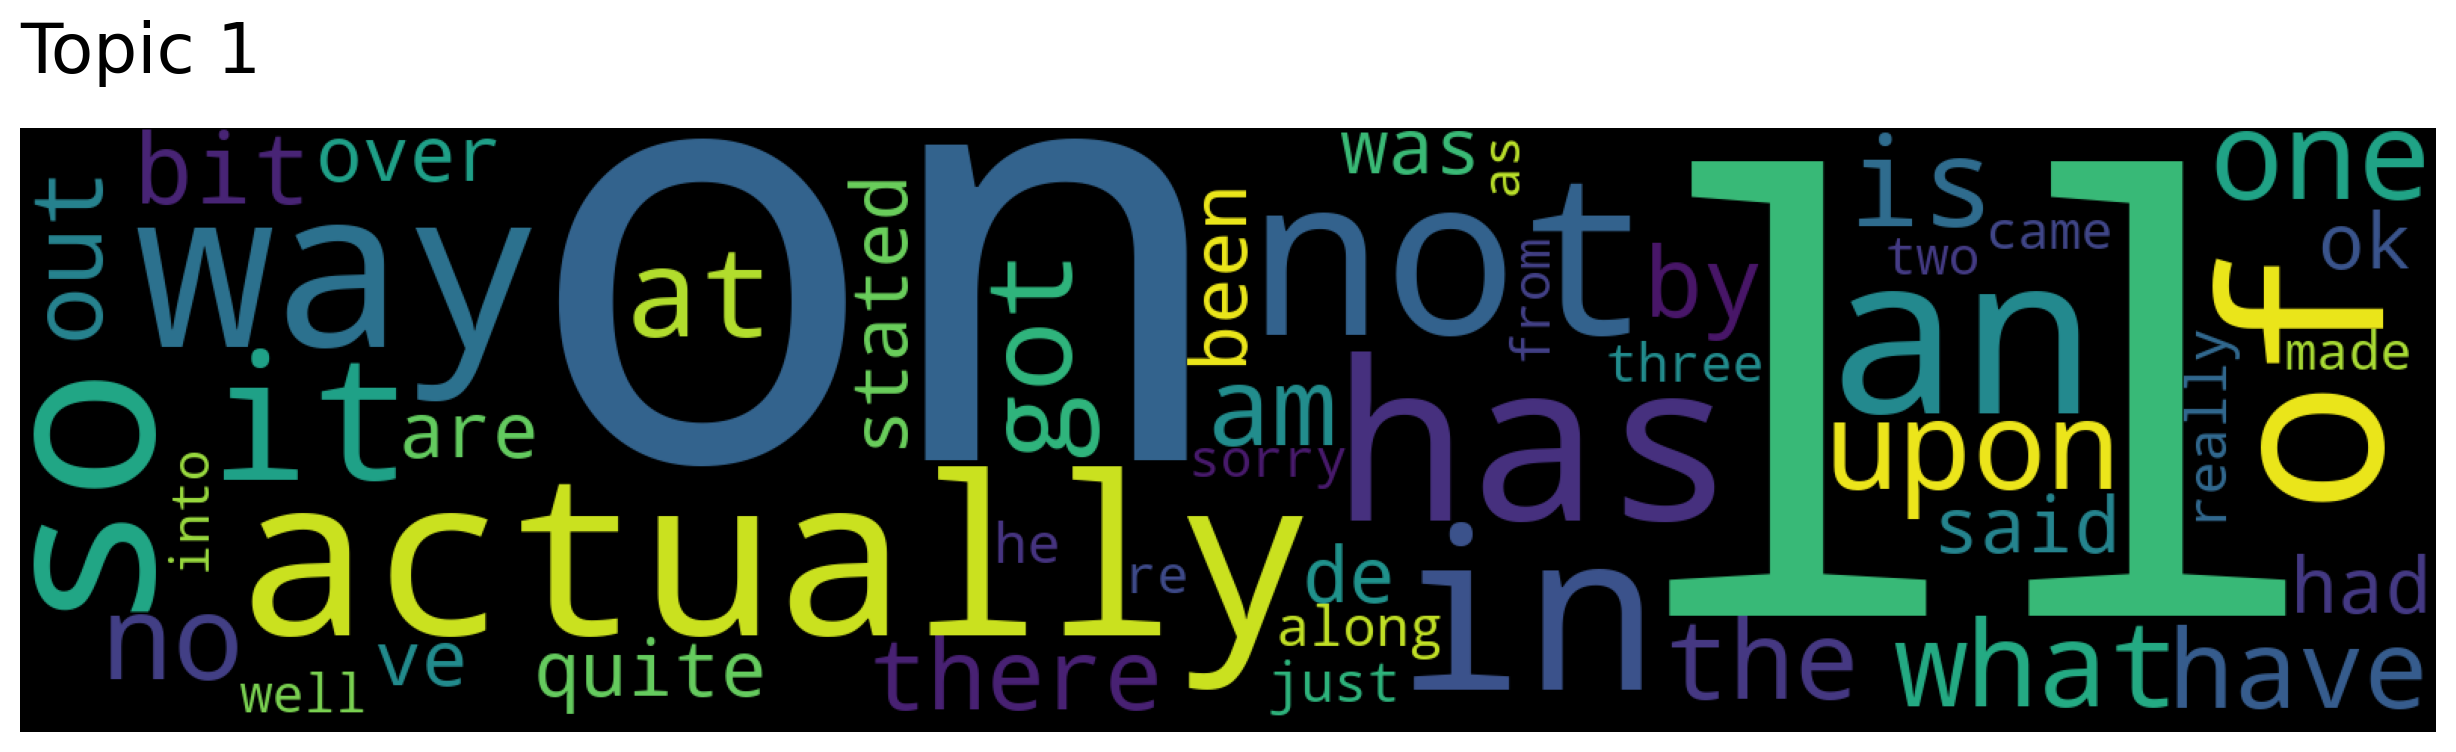

In [16]:
for topic in topic_nums:
    model.generate_topic_wordcloud(topic)

Bad :(<br/>
Stop words are in one topic and all other words are in another topic



### BertTopic

In depth [explanation](https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6)<br/>
How to use [it](https://towardsdatascience.com/interactive-topic-modeling-with-bertopic-1ea55e7d73d8)<br/>
[Github](https://github.com/MaartenGr/BERTopic/)

Every run produces different number of topics

In [17]:
topic_model = BERTopic(language="english", calculate_probabilities=True) # We need the probabilities to visualize, nr_topics="auto" => to reduce number of topics
topics, probs = topic_model.fit_transform(docs)

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/314 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Predictions

In [18]:
print(type(topics))
print(len(topics))
print(topics[0])

<class 'list'>
2218
1


In [19]:
print(type(probs))
print(probs.shape)
print(probs[0])

<class 'numpy.ndarray'>
(2218, 29)
[0.02082911 0.59813982 0.02146813 0.02405554 0.00879978 0.0114928
 0.00959126 0.00212549 0.00985999 0.01139973 0.01158799 0.00821827
 0.02678668 0.02680029 0.00876325 0.01077129 0.01392859 0.02275216
 0.01065683 0.02923158 0.013349   0.00889889 0.00893465 0.01725867
 0.00951476 0.02376059 0.01069109 0.01110089 0.00923286]


In [20]:
df = topic_model.get_topic_info()
df

,Topic,Count,Name
0,-1,693,-1_are_as_be_with
1,0,455,0_space_at_be_nasa
2,1,167,1_fbi_were_fire_had
3,2,101,2_this_jesus_will_he
4,3,97,3_gun_guns_are_as
5,4,87,4_god_jesus_he_his
6,5,60,5_islam_islamic_muslim_muslims
7,6,52,6_church_pope_catholic_schism
8,7,52,7_forcibly_foot_foote_foothold
9,8,51,8_god_atheism_atheists_atheist


Custom vectorizer

In [21]:
cv = CountVectorizer(ngram_range=(1, 3), stop_words="english")
res = topic_model.update_topics(docs, topics, vectorizer_model=cv)

In [22]:
df = topic_model.get_topic_info()
df

,Topic,Count,Name
0,-1,693,-1_god_gun_think_say
1,0,455,0_nasa_satellite_lunar_orbit
2,1,167,1_fbi_gas_tanks_children
3,2,101,2_jesus_matthew_god_prophecy
4,3,97,3_gun_guns_crime_weapons
5,4,87,4_god_jesus_sin_paul
6,5,60,5_islam_islamic_muslim_muslims
7,6,52,6_church_pope_catholic_bishop
8,7,52,7_fortunately learned_fortunate sculptor findi...
9,8,51,8_god_atheism_atheists_atheist


Compare topics with targets

In [23]:
def find_real_target(row, target):
    docs_ids = []
    for i in range(len(topics)):
        if topics[i] == row['Topic']:
            docs_ids.append(i)

    targets = []
    for i in docs_ids:
        targets.append(target_names[y[i]])

    return targets.count(target)

for target in target_names:
    df[target] = df.apply(lambda row: find_real_target(row, target), axis=1)

df['Real_Target'] = df[target_names].idxmax(axis=1)
df

,Topic,Count,Name,alt.atheism,sci.space,soc.religion.christian,talk.politics.guns,Real_Target
0,-1,693,-1_god_gun_think_say,171,70,235,217,soc.religion.christian
1,0,455,0_nasa_satellite_lunar_orbit,6,435,4,10,sci.space
2,1,167,1_fbi_gas_tanks_children,12,17,5,133,talk.politics.guns
3,2,101,2_jesus_matthew_god_prophecy,39,26,17,19,alt.atheism
4,3,97,3_gun_guns_crime_weapons,0,0,1,96,talk.politics.guns
5,4,87,4_god_jesus_sin_paul,4,1,82,0,soc.religion.christian
6,5,60,5_islam_islamic_muslim_muslims,55,0,4,1,alt.atheism
7,6,52,6_church_pope_catholic_bishop,2,0,50,0,soc.religion.christian
8,7,52,7_fortunately learned_fortunate sculptor findi...,12,17,9,14,sci.space
9,8,51,8_god_atheism_atheists_atheist,41,0,10,0,alt.atheism


In [24]:
topic_model.visualize_topics()

In [25]:
topic_model.get_topic(topic_model.get_topic_freq()['Topic'].iloc[1])

[('nasa', 0.006644232136357621),
 ('satellite', 0.005304702179732203),
 ('lunar', 0.0052736533723802305),
 ('orbit', 0.005268048249867316),
 ('moon', 0.004624266860753938),
 ('mission', 0.004292369576010046),
 ('spacecraft', 0.0037270309035806895),
 ('solar', 0.00335893009509279),
 ('satellites', 0.003320612195910463),
 ('mars', 0.0032394164471119965)]

Reduce number of topics for already trained model

In [ ]:
topic_model.reduce_topics(docs, topics, probs, nr_topics="auto") # "auto"

In [ ]:
info = pd.DataFrame(topic_model.topic_sizes.items(), columns=['Topic', 'Count']).sort_values("Count", ascending=False)
info["Name"] = info.Topic.map(topic_model.topic_names)
info

Explore documents per topic

In [28]:
topic_id = -1
num_of_docs = 5
counter = 0
for i in range(len(topics)):
    if topics[i] == topic_id:
        print(docs[i])
        print('\n', '---------------------------------------------------------------', '\n')
        counter += 1
        if counter == num_of_docs:
            break

definitely a lemur. Elvis couldn't spell, just listen to any of his songs.

 --------------------------------------------------------------- 

Exactly, after all he was in the same party, probably just didn't want the bad press that being directly associated with Duke would bring. Conversely, is his disdain for David Duke supposed to make us ideolize him? I mean a stand against neo-nazism ... Whoa! Now that's progressive! Come on. I certainly know that I would refuse and openly denounce my Vice Presidency if it meant putting him in control. --Stephen White

 --------------------------------------------------------------- 

-> Actually, the words "A well regulated Milita, being necessary to the -> security of a free state" is a present participle, used as an -> adjective to modify 'militia', which is followed by the main clause of -> the sentence, the subject being 'the right', the verb 'shall'. It -> asserts that the right to keep and bear arms is essential for -> maintaining a milita.

### Prepare data for statistical models

In [29]:
# Initialize spacy 'en' model, keeping only tagger component needed for lemmatization
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [30]:
def preprocess(text):
    text = text.lower()
    text = text.strip()
    text = re.sub('\d', '', text)  # remove numbers 
    text = ' '.join(text.split())  # replace whitespace with single space

    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token for token in tokens if len(token) > 1]

    return ' '.join(tokens)

In [31]:
X_clean = [preprocess(doc) for doc in X]

Let's fit vectorizer with preprocessed data

In [32]:
vectorizer = CountVectorizer(max_df=0.95, 
                             min_df=2,
                             max_features=1000)

tf = vectorizer.fit_transform(X_clean)
vocabulary = vectorizer.get_feature_names()

### LDA

In [33]:
lda = LatentDirichletAllocation(n_components=20,
                                max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=RANDOM_STATE)
lda.fit(tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=50.0,
                          max_doc_update_iter=100, max_iter=5,
                          mean_change_tol=0.001, n_components=20, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

### HDP